In [2]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pylab import rcParams

from keras.models import Sequential
from keras.layers import LSTM, Dense

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from src.evaluation.evaluation import MetricEvaluator

In [3]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)

In [4]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [5]:
train, val, test = split_series(df_brl)

Treino + Val ACUCAR_SANTOS: 45 | Teste ACUCAR_SANTOS: 20
Treino + Val ACUCAR_SP: 185 | Teste ACUCAR_SP: 80
Treino + Val ALGODAO: 243 | Teste ALGODAO: 105
Treino + Val ARROZ: 168 | Teste ARROZ: 72
Treino + Val CAFE_ARABICA: 241 | Teste CAFE_ARABICA: 104
Treino + Val CAFE_ROBUSTA: 201 | Teste CAFE_ROBUSTA: 87
Treino + Val MILHO: 175 | Teste MILHO: 75
Treino + Val SOJA_PARANA: 234 | Teste SOJA_PARANA: 101
Treino + Val SOJA_PARANAGUA: 161 | Teste SOJA_PARANAGUA: 70
Treino + Val TRIGO_PARANA: 179 | Teste TRIGO_PARANA: 77
Treino + Val TRIGO_RS: 179 | Teste TRIGO_RS: 77
Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


In [6]:
def criar_janelas(df, n_lags=12):
    """
    Cria janelas (X, y) para cada unique_id separadamente
    """
    Xs, ys = [], []
    for uid, df_uid in df.groupby("unique_id"):
        serie = df_uid["y"].values
        for i in range(len(serie) - n_lags):
            Xs.append(serie[i:i+n_lags])
            ys.append(serie[i+n_lags])
    X = np.array(Xs).reshape(-1, n_lags, 1)
    y = np.array(ys)
    return X, y

In [7]:
n_lags = 12
full_train = pd.concat([train, val])

X_train, y_train = criar_janelas(full_train, n_lags=n_lags)

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(n_lags, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=50, verbose=1, batch_size=32)

2025-10-06 23:25:27.562681: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


AttributeError: 'Pipeline' object has no attribute 'compile'

In [ ]:
forecasts = []

for uid, df_test in test.groupby("unique_id"):
    # pegar última janela do full_train
    serie_hist = full_train[full_train["unique_id"] == uid]["y"].values
    janela = serie_hist[-n_lags:].reshape((1, n_lags, 1))
    
    preds_uid = []
    
    for i in range(len(df_test)):
        # previsão
        pred = model.predict(janela, verbose=0)[0][0]
        
        preds_uid.append({
            "unique_id": uid,
            "ds": df_test.iloc[i]["ds"],
            "lstm": pred
        })
        
        # update com valor real
        valor_real = df_test.iloc[i]["y"]
        nova_janela = np.append(janela.flatten()[1:], valor_real)
        janela = nova_janela.reshape((1, n_lags, 1))
    
    forecasts.append(pd.DataFrame(preds_uid))

forecasts_df = pd.concat(forecasts, ignore_index=True)

In [ ]:
evaluator = MetricEvaluator()
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['lstm'],         
    groupby_column='unique_id'     
)

In [ ]:
print(results)

         unique_id Model  n_observations         MAE      MAPE            MSE  \
0    ACUCAR_SANTOS  lstm              20    7.087637  0.047579      75.888263   
1        ACUCAR_SP  lstm              80    4.125504  0.034990      30.308256   
2          ALGODAO  lstm             105   17.052302  0.039560     651.053558   
3            ARROZ  lstm              72    4.176967  0.048205      32.306046   
4     CAFE_ARABICA  lstm             104  225.560620  0.157230  200933.653850   
5     CAFE_ROBUSTA  lstm              87  131.140544  0.107270   89269.162538   
6            MILHO  lstm              75    3.692662  0.052939      23.011313   
7      SOJA_PARANA  lstm             101    4.715278  0.038830      46.892150   
8   SOJA_PARANAGUA  lstm              70    5.404237  0.037543      53.863136   
9     TRIGO_PARANA  lstm              77  521.465161  0.336614  376378.504616   
10        TRIGO_RS  lstm              77  450.330926  0.305436  293379.229718   

          RMSE        R2  


In [ ]:
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)


=== Estatísticas Resumo ===
            MAE                                        MAPE                 \
           mean       std     min       max  median    mean     std    min   
Model                                                                        
lstm   124.9774  192.7244  3.6927  521.4652  7.0876  0.1097  0.1112  0.035   

                              MSE                                              \
          max  median        mean          std      min          max   median   
Model                                                                           
lstm   0.3366  0.0482  87352.1703  138615.1098  23.0113  376378.5046  75.8883   

           RMSE                                         R2                  \
           mean       std    min       max  median    mean     std     min   
Model                                                                        
lstm   178.7798  246.8379  4.797  613.4969  8.7114  0.2556  1.1845 -2.4186   

                    

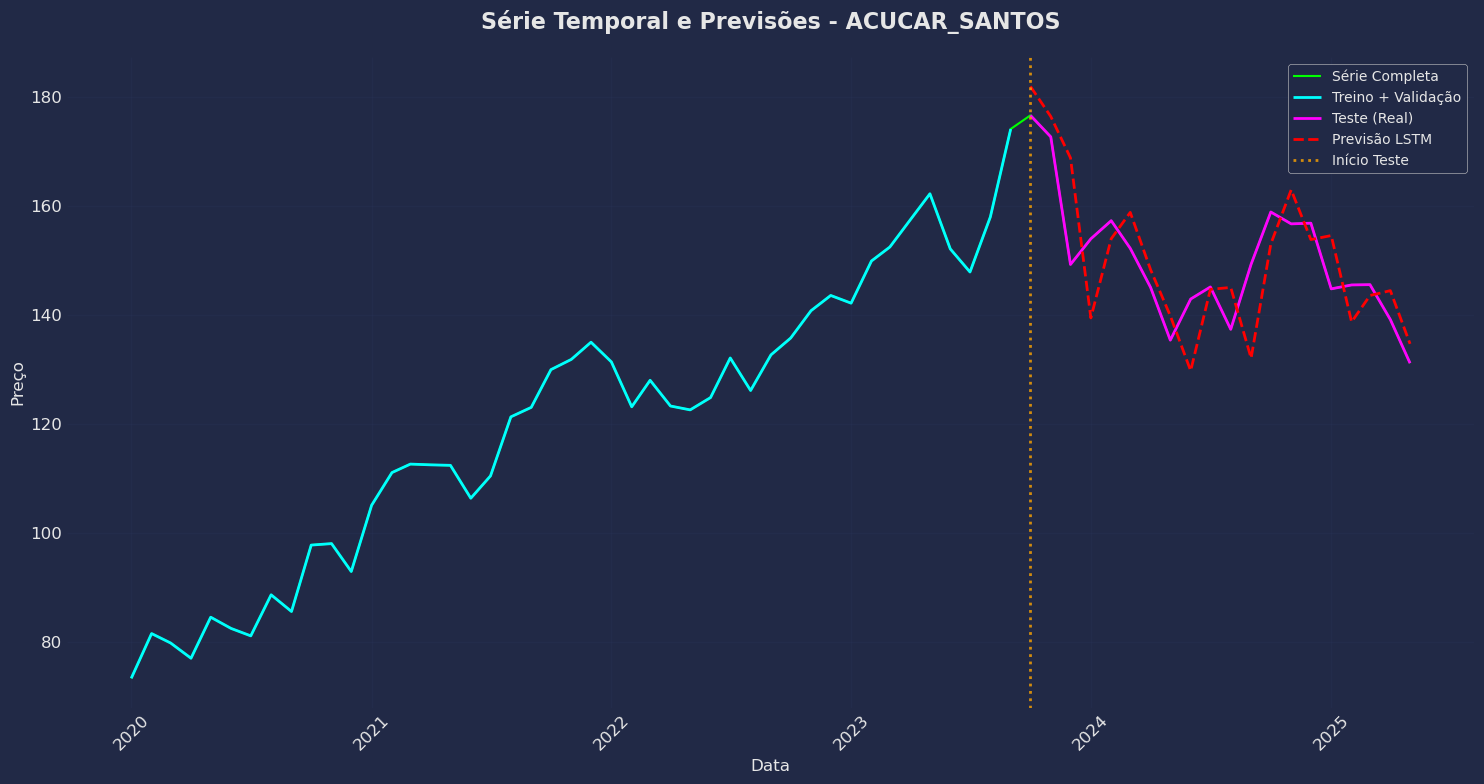

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


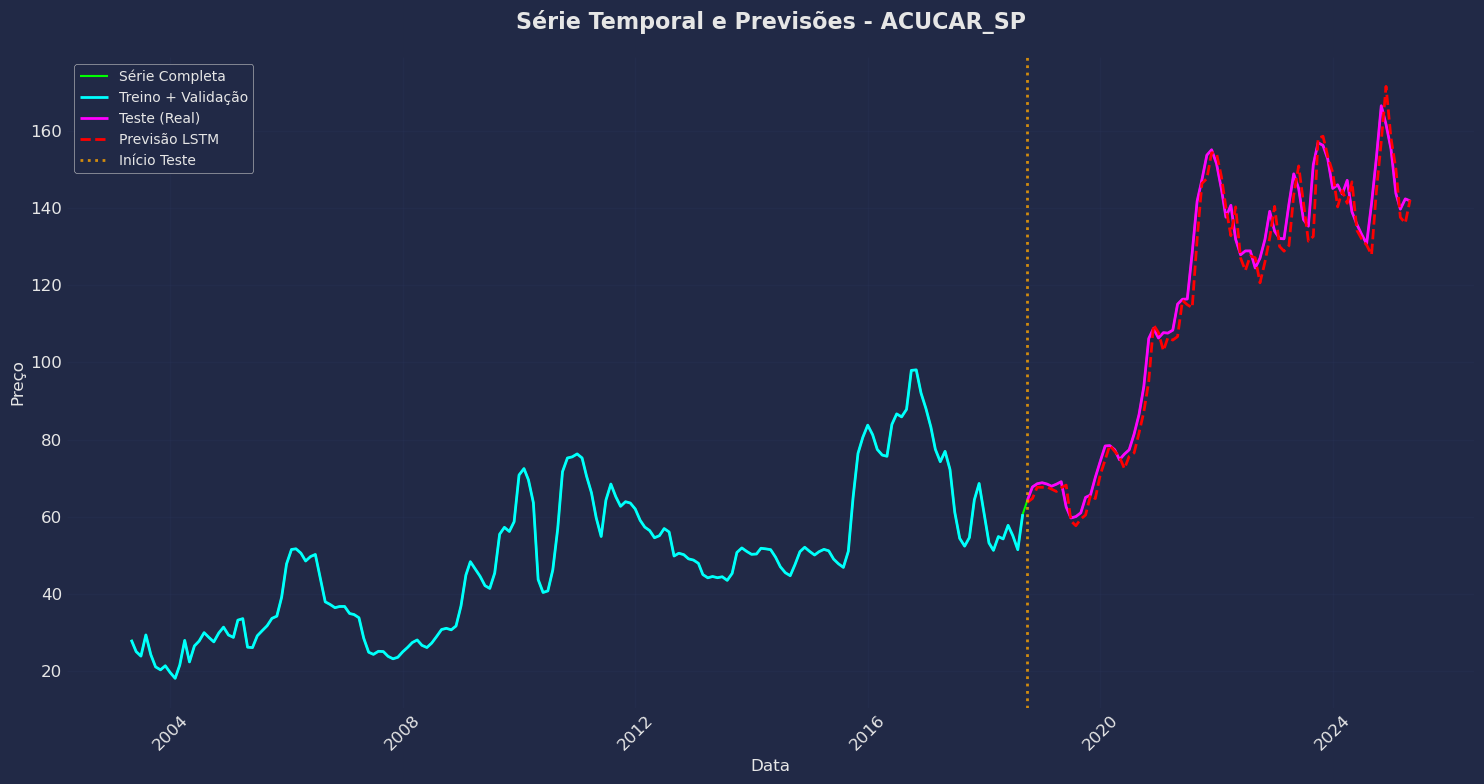

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


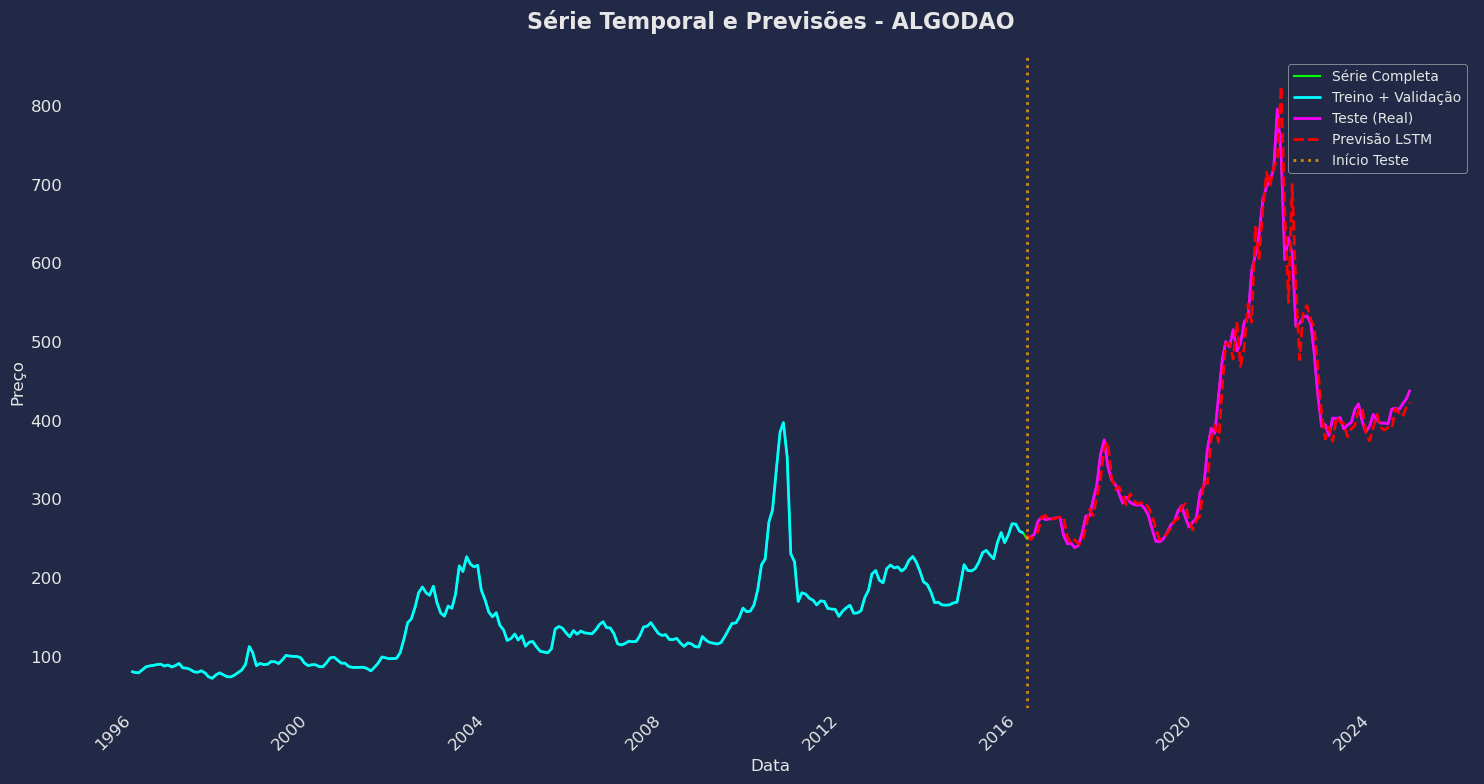

Gráfico exibido para: ALGODAO
--------------------------------------------------


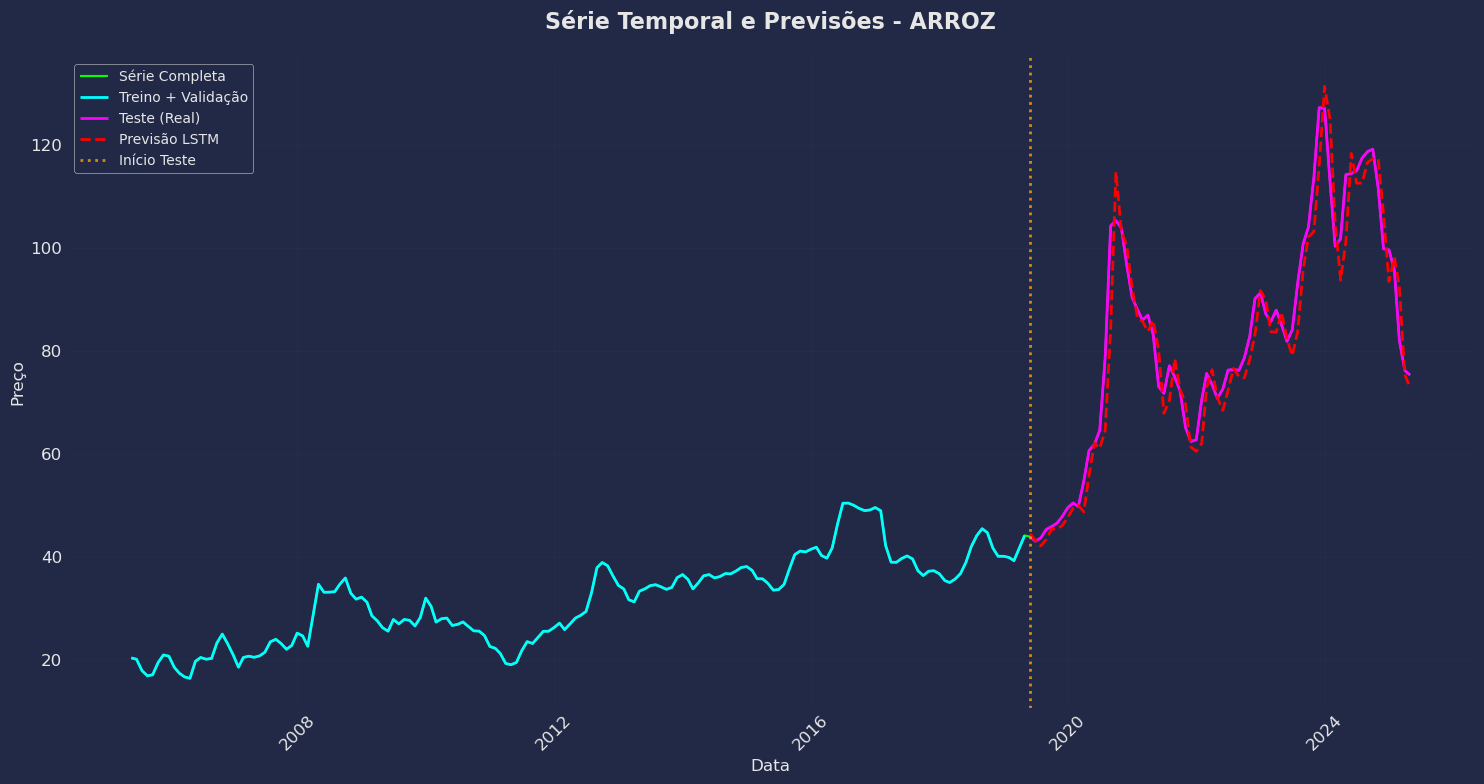

Gráfico exibido para: ARROZ
--------------------------------------------------


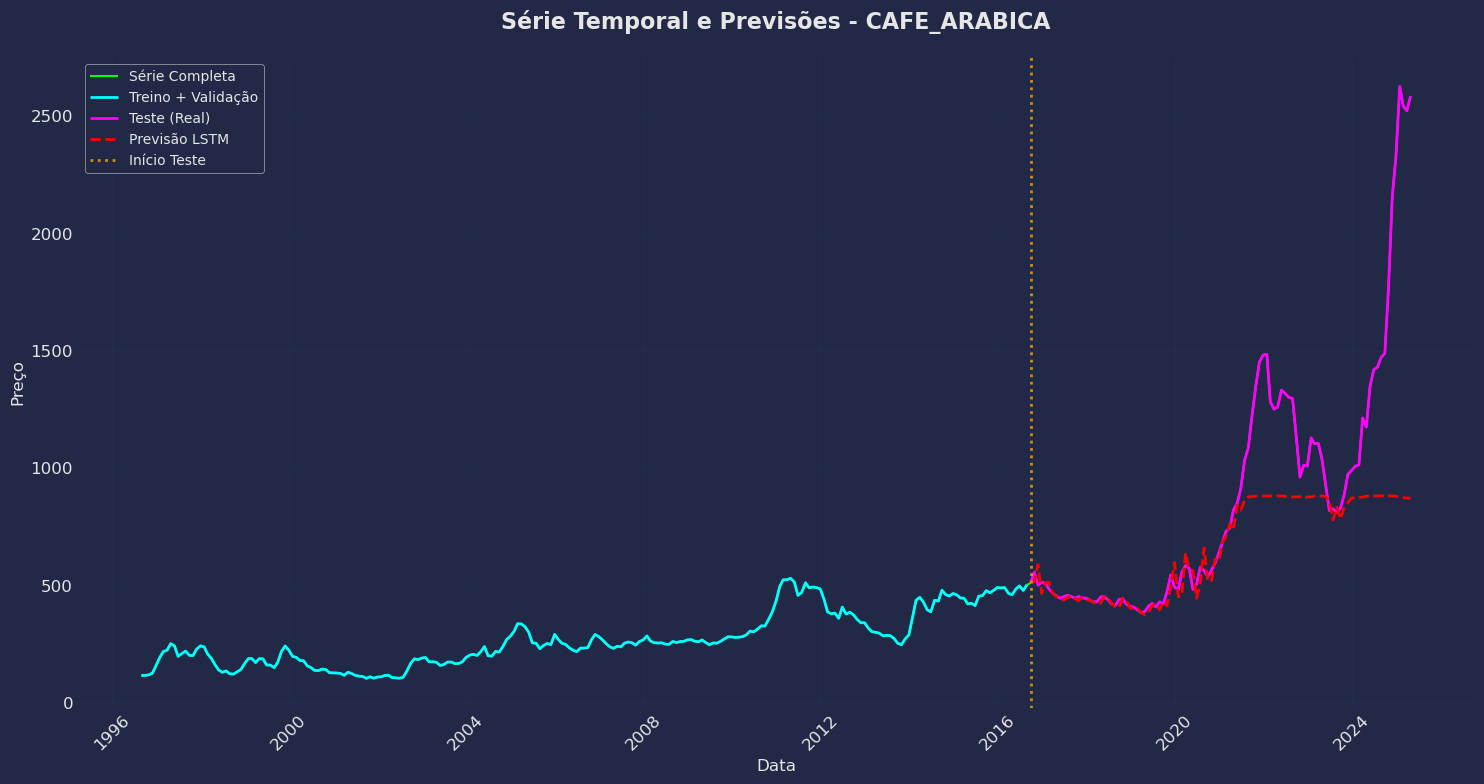

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


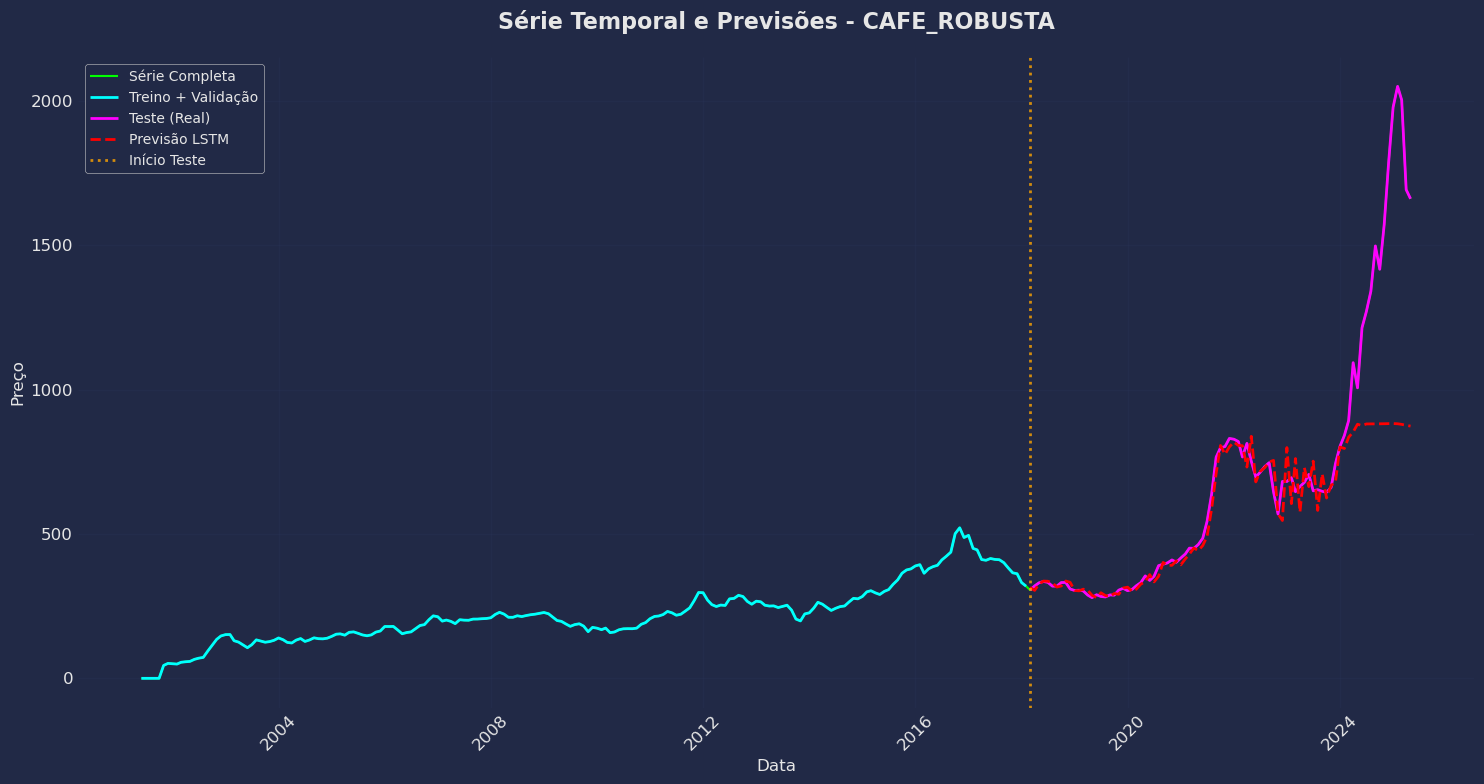

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


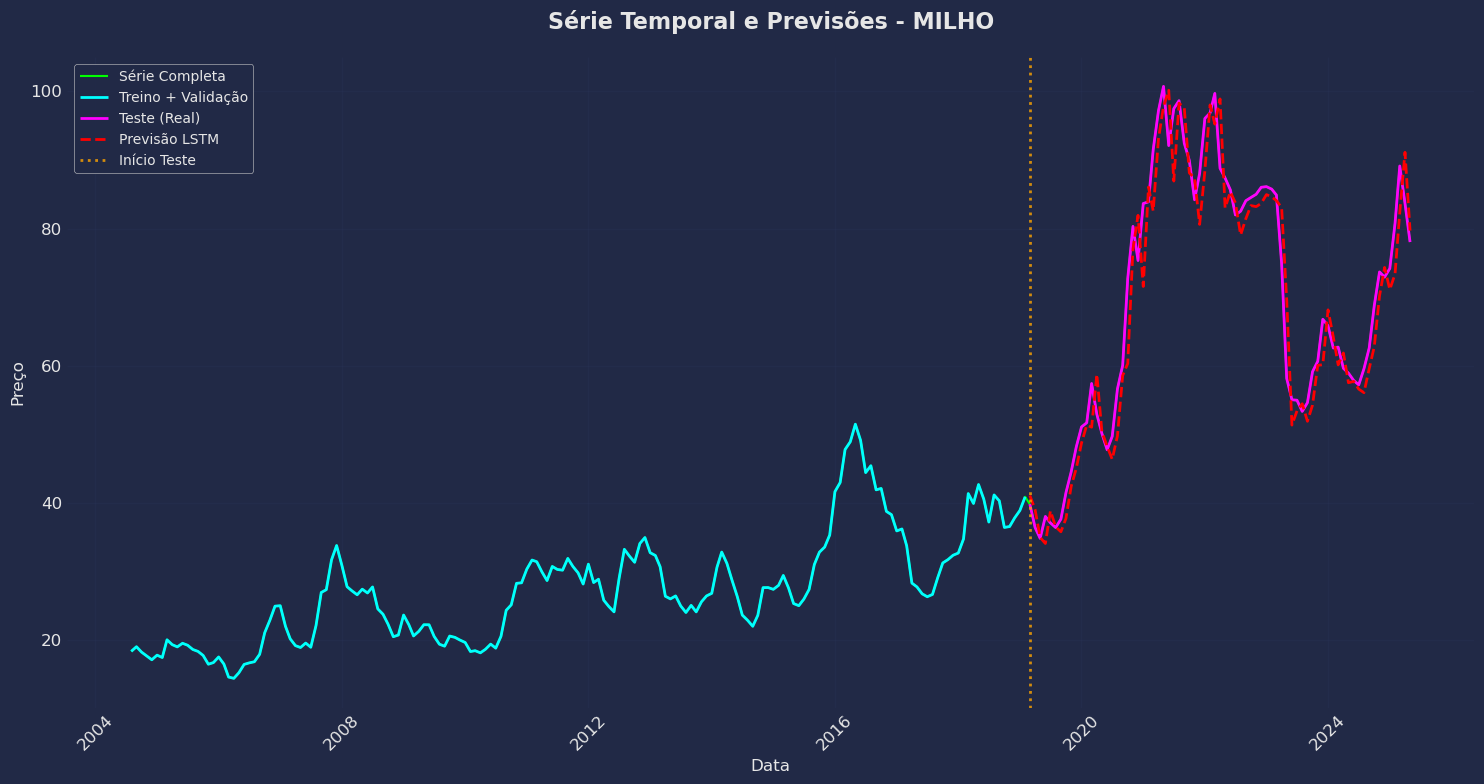

Gráfico exibido para: MILHO
--------------------------------------------------


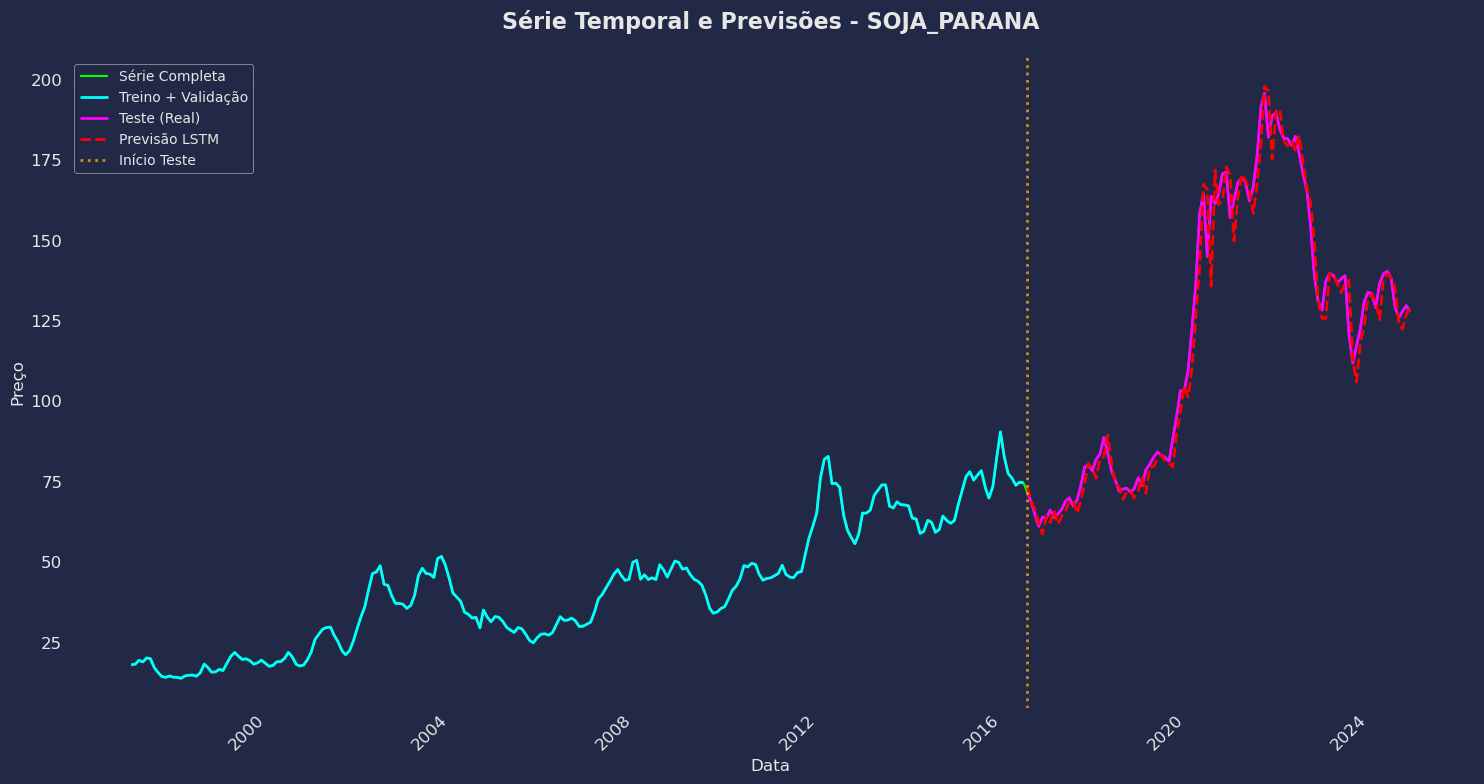

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


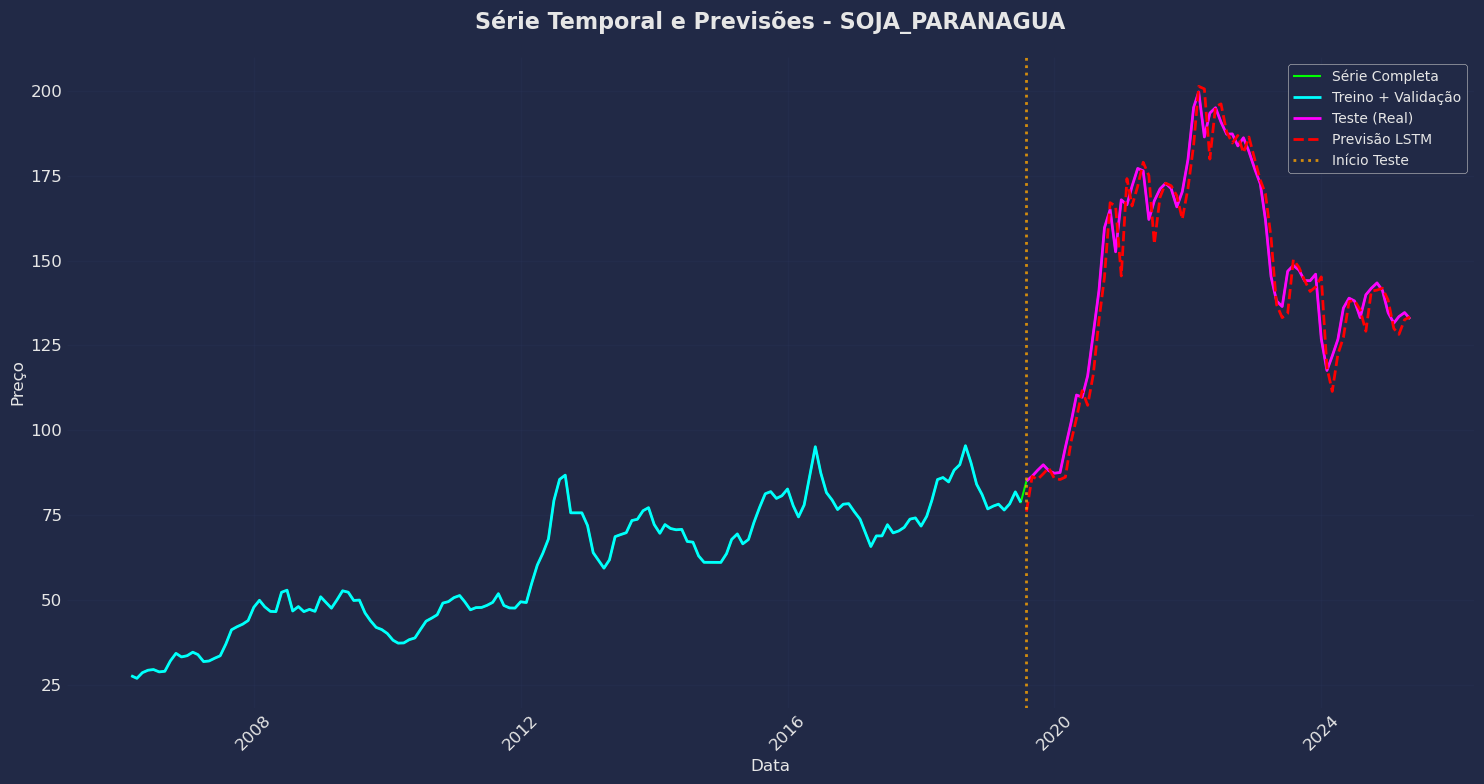

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


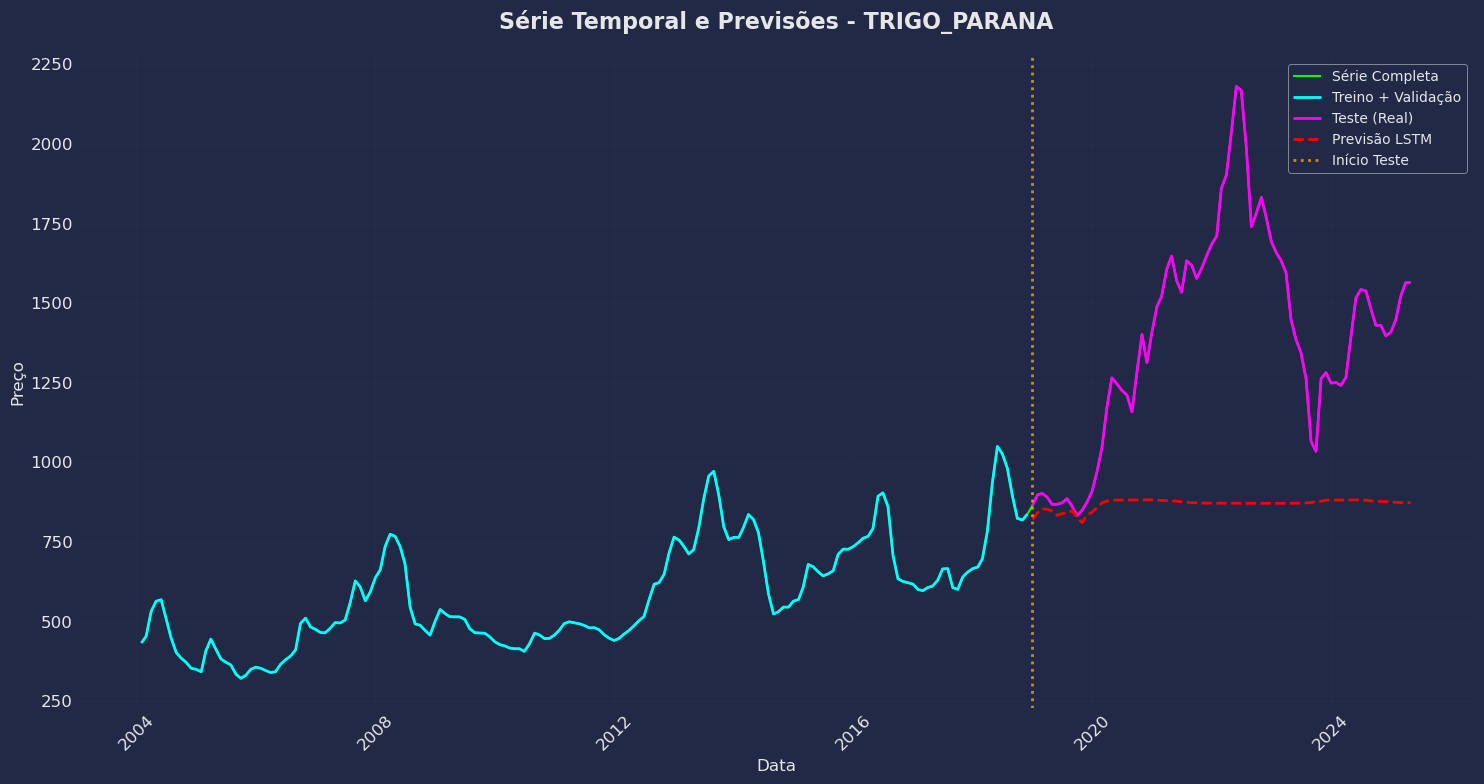

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


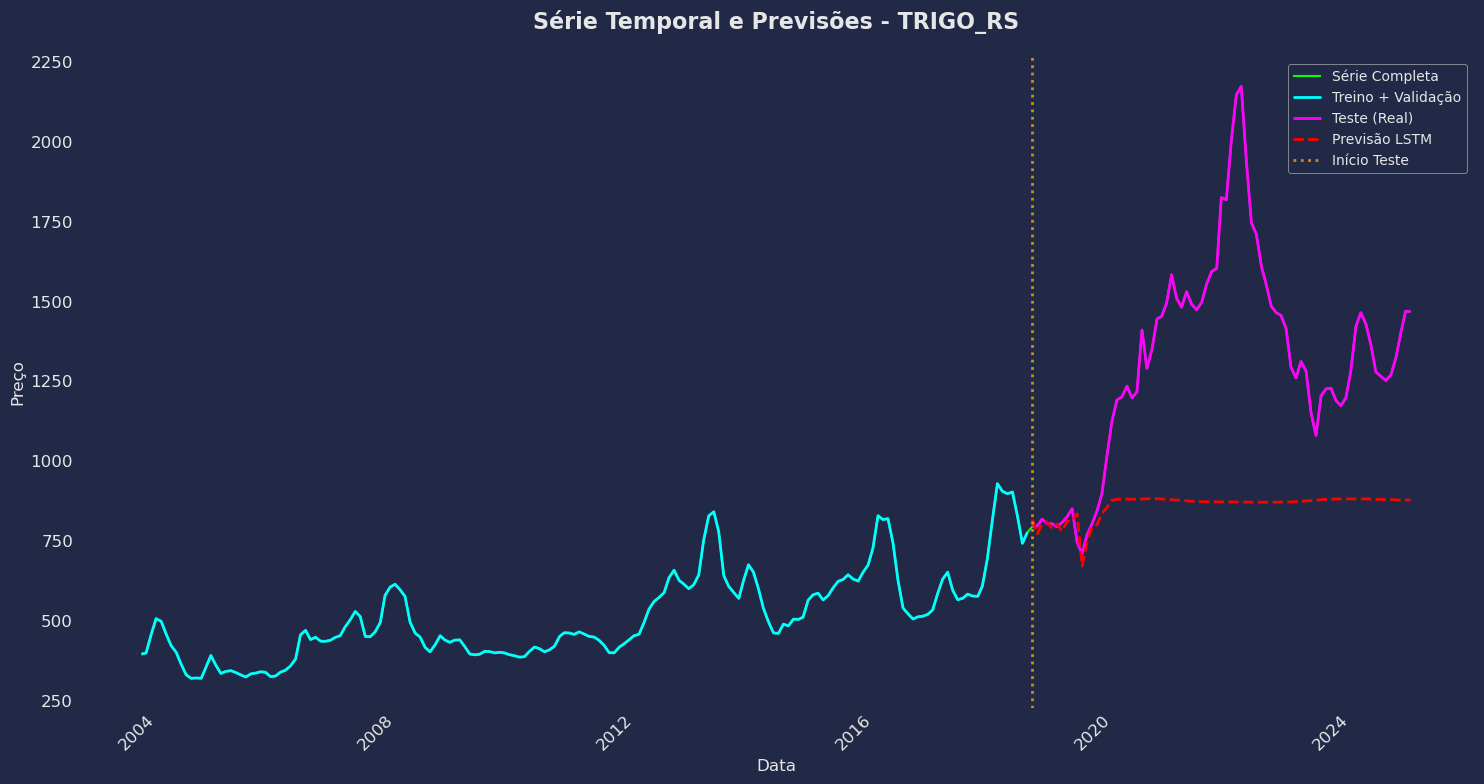

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [ ]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lime', linewidth=1.5, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='cyan', linewidth=2, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='fuchsia', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['lstm'], 
                color='red', linewidth=2, linestyle='--', label='Previsão LSTM')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)